In [2]:
from code.io.EventProcessor import EventProcessor
from code.io.TrackingProcessor import TrackingProcessor
from code.io.PossessionProcessor import PossessionProcessor
from code.io.ActionProcessor import ActionProcessor

from code.util.StatsUtil import StatsUtil
from code.util.ShotRegionUtil import ShotRegionUtil
from code.util.VisUtil import VisUtil
from code.util.FeatureUtil import FeatureUtil

import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'

ModuleNotFoundError: No module named 'pandas'

In [2]:
GAME_ID = "0022300869"

event_df = EventProcessor.load_games()
tracking_df = TrackingProcessor.load_games()
possession_df = PossessionProcessor.load_games()

In [3]:
# true_point_events = StatsUtil.calculate_true_points(event_df)
# true_point_events.to_csv('true_points.csv')
# true_point_events['true_points_produced'].value_counts()

In [4]:
# transition_events = EventProcessor.extract_transition_opportunities(event_df)
# event = transition_events[0]
# start, end = EventProcessor.get_start_end_time_of_event(event)
# moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, start, end)
# possession = PossessionProcessor.extract_possession_by_timestamp(possession_df, end)
# cross_3pt = FeatureUtil.find_ball_crossing_far_three_point_line(moment_df, possession.iloc[0]["basketX"])
# cross_half = FeatureUtil.find_ball_crossing_halfcourt(moment_df, possession.iloc[0]["basketX"])
# in_zone_of_death = FeatureUtil.find_ball_moment(moment_df, FeatureUtil.is_in_zone_of_death, possession.iloc[0]["basketX"])
# print(cross_3pt, cross_half, in_zone_of_death)

          gameId playerId        playerName      teamId teamAbbr  period  \
0     0022300336  1630168    Onyeka Okongwu  1610612737      ATL       1   
1     0022300336  1629631    DeAndre Hunter  1610612737      ATL       1   
2     0022300336  1629027        Trae Young  1610612737      ATL       1   
3     0022300336  1627749   Dejounte Murray  1610612737      ATL       1   
4     0022300336  1630180        Saddiq Bey  1610612737      ATL       1   
...          ...      ...               ...         ...      ...     ...   
3592  0022300336  1629622         Max Strus  1610612739      CLE       1   
3593  0022300336  1629731         Dean Wade  1610612739      CLE       1   
3594  0022300336  1628378  Donovan Mitchell  1610612739      CLE       1   
3595  0022300336  1628386     Jarrett Allen  1610612739      CLE       1   
3596  0022300336      NaN               NaN          -1      NaN       1   

             wcTime  gcTime  scTime      x      y     z    gameDate  
0     17027737328

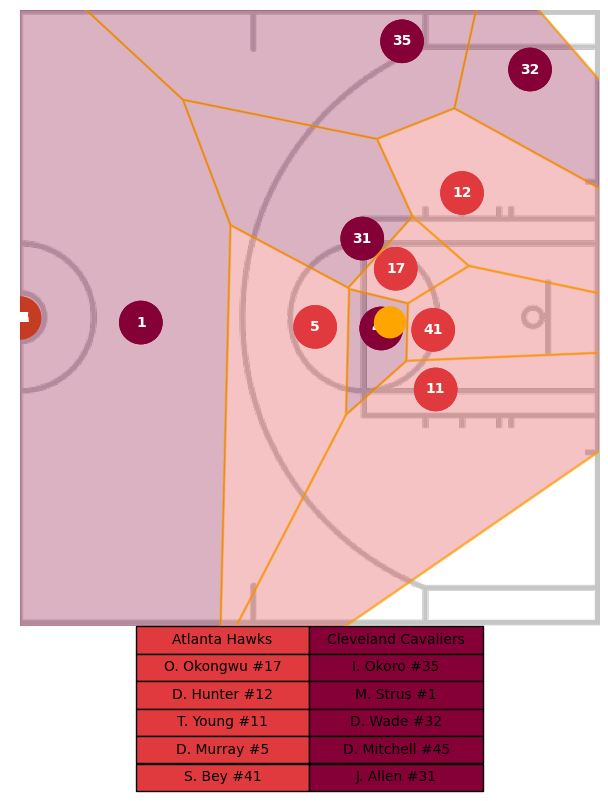

In [5]:
shot_rebound_classified_df = pd.read_csv('./data/results/shot_rebound_classified.csv')
hexbin_region_data_df = pd.read_csv('./data/results/rebound_hexmap_distributions.csv')

possession = shot_rebound_classified_df.iloc[0]
moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, possession['wcStart'], possession['wcEnd'])
print(moment_df)
moment_df = TrackingProcessor.mirror_court_data(moment_df, 'x', 'y', -possession["basket_x"])
print(moment_df)
anim = VisUtil(moment_df)
anim.plot_voronoi_at_timestamp(possession['shot_time'], -possession["basket_x"])

In [6]:
print(possession)
rebound_regions_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)

StatsUtil.calculate_rebound_chances(moment_df, possession['shot_time'], hexbin_region_data_df, 41.75)

Unnamed: 0                                              598
shot_x                                               -30.05
shot_y                                                 0.35
rebound_x                                            -39.46
rebound_y                                              3.98
shot_time                                     1702773744600
rebound_time                                  1702773745880
rebound_teamId                                   1610612737
basket_x                                             -41.75
gameId                                             22300336
period                                                    1
possId                 46150e42-5f57-508b-aa7e-05b0c3e1bc56
possNum                                                   3
teamId                                           1610612739
teamAbbr                                                CLE
outcome                                                 FGX
ptsScored                               

c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_df[x_col_name] = tracking_df.apply(
c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_df[y_col_name] = tracking_df.apply(
c:\Users\dkste\Dev\TrueImpactShotCharts\code\io\TrackingProcessor.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

inside calculate_rebound_chances with:  1702773744600 41.75
          gameId playerId        playerName      teamId teamAbbr  period  \
0     0022300336  1630168    Onyeka Okongwu  1610612737      ATL       1   
1     0022300336  1629631    DeAndre Hunter  1610612737      ATL       1   
2     0022300336  1629027        Trae Young  1610612737      ATL       1   
3     0022300336  1627749   Dejounte Murray  1610612737      ATL       1   
4     0022300336  1630180        Saddiq Bey  1610612737      ATL       1   
...          ...      ...               ...         ...      ...     ...   
3592  0022300336  1629622         Max Strus  1610612739      CLE       1   
3593  0022300336  1629731         Dean Wade  1610612739      CLE       1   
3594  0022300336  1628378  Donovan Mitchell  1610612739      CLE       1   
3595  0022300336  1628386     Jarrett Allen  1610612739      CLE       1   
3596  0022300336      NaN               NaN          -1      NaN       1   

             wcTime  gcTime

({'1630168': 19.30635838150289,
  '1629631': 19.30635838150289,
  '1629027': 19.30635838150289,
  '1627749': 19.30635838150289,
  '1630180': 19.30635838150289,
  '1630171': 0.6936416184971098,
  '1629622': 0.6936416184971098,
  '1629731': 0.6936416184971098,
  '1628378': 0.6936416184971098,
  '1628386': 0.6936416184971098},
 {'1610612737': 96.53179190751445, '1610612739': 3.4682080924855487})

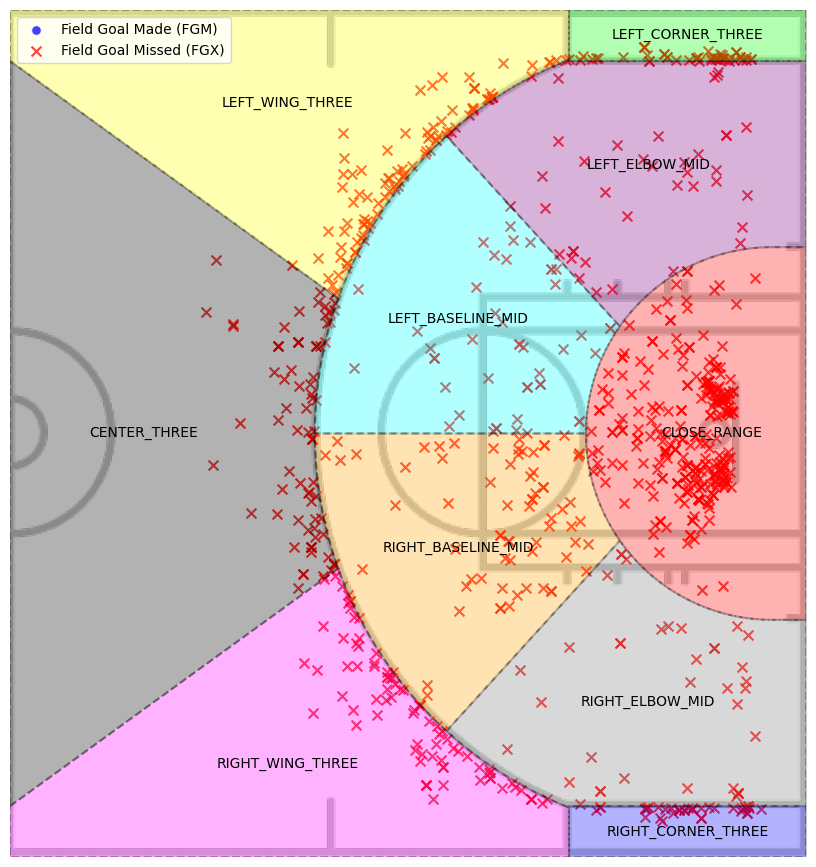

In [7]:
shot_rebound_df = ActionProcessor.extract_shots_and_rebounds(event_df, tracking_df, possession_df)
shot_rebound_classified_df = FeatureUtil.classify_shot_locations(shot_rebound_df, possession_df, FeatureUtil.classify_shot_region)
VisUtil.plot_shots_and_regions(shot_rebound_classified_df)

In [8]:
shot_rebound_classified_df['shot_classification'].value_counts()

shot_classification
CLOSE_RANGE           272
RIGHT_WING_THREE       99
LEFT_WING_THREE        83
CENTER_THREE           80
LEFT_BASELINE_MID      69
RIGHT_BASELINE_MID     46
RIGHT_CORNER_THREE     45
RIGHT_ELBOW_MID        40
LEFT_CORNER_THREE      40
LEFT_ELBOW_MID         38
Name: count, dtype: int64

In [9]:
# shot_rebound_classified_df = pd.read_csv('./data/results/shot_rebound_classified.csv')
# VisUtil.plot_court_hexmap(shot_rebound_classified_df, 'rebound_x', 'rebound_y')
# rebound_regions_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)
# rebound_regions_df.to_csv('./data/results/rebound_hexmap_distributions.csv')

In [11]:
StatsUtil.assign_rebound_chances_to_shots(shot_rebound_classified_df, tracking_df, hexbin_region_data_df)

inside calculate_rebound_chances with:  1702773745880 -41.75
             gameId playerId        playerName      teamId teamAbbr  period  \
4752715  0022300336  1630168    Onyeka Okongwu  1610612737      ATL       1   
4752716  0022300336  1629631    DeAndre Hunter  1610612737      ATL       1   
4752717  0022300336  1629027        Trae Young  1610612737      ATL       1   
4752718  0022300336  1627749   Dejounte Murray  1610612737      ATL       1   
4752719  0022300336  1630180        Saddiq Bey  1610612737      ATL       1   
...             ...      ...               ...         ...      ...     ...   
5544820  0022300336  1627777     Georges Niang  1610612739      CLE       4   
5544821  0022300336  1627747      Caris LeVert  1610612739      CLE       4   
5544822  0022300336   202684  Tristan Thompson  1610612739      CLE       4   
5544823  0022300336  1630171       Isaac Okoro  1610612739      CLE       4   
5544824  0022300336      NaN               NaN          -1      NaN   

,shot_x,shot_y,rebound_x,rebound_y,shot_time,rebound_time,rebound_teamId,basket_x,gameId,period,...,teamAbbr,outcome,ptsScored,wcStart,wcEnd,gcStart,gcEnd,shot_classification,off_reb_chance,def_reb_chance
598,30.05,-0.35,-39.46,3.98,1702773744600,1702773745880,1610612737,-41.75,0022300336,1,...,CLE,FGX,0,1702773732840,1702773745880,678.45,665.41,LEFT_BASELINE_MID,44.444444,55.555556
2589,42.44,22.00,39.22,0.49,1702773806280,1702773808480,1610612739,41.75,0022300336,1,...,ATL,FGX,0,1702773793560,1702773808480,635.36,620.44,RIGHT_ELBOW_MID,0.000000,100.000000
4579,33.37,-6.39,37.13,0.41,1702773896040,1702773897680,1610612739,41.75,0022300336,1,...,ATL,FGX,0,1702773884640,1702773897680,575.00,561.96,LEFT_BASELINE_MID,0.000000,100.000000
6571,34.61,-22.21,42.73,7.68,1702773922320,1702773924400,1610612739,41.75,0022300336,1,...,ATL,FGX,0,1702773908480,1702773924400,551.16,535.24,LEFT_CORNER_THREE,0.000000,100.000000
8563,19.21,7.71,27.20,-1.35,1702774147160,1702774149280,1610612739,41.75,0022300336,1,...,ATL,FGX,0,1702774108520,1702774149280,526.83,504.16,CENTER_THREE,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610974,27.81,-8.54,43.08,-4.55,1709437076600,1709437078200,1610612743,41.75,0022300869,4,...,LAL,FGX,0,1709437061520,1709437078200,186.93,170.25,LEFT_BASELINE_MID,0.000000,100.000000
1612966,38.79,-1.42,40.65,-0.27,1709437113480,1709437114720,1610612743,41.75,0022300869,4,...,LAL,FGX,0,1709437101000,1709437114720,147.45,133.73,CLOSE_RANGE,85.365854,14.634146
1614956,25.59,-19.71,41.40,-3.46,1709437277120,1709437278600,1610612743,41.75,0022300869,4,...,LAL,FGX,0,1709437270720,1709437278600,94.17,88.42,LEFT_WING_THREE,0.000000,100.000000
1616950,25.59,-19.71,-43.92,-9.70,1709437277120,1709437300320,1610612743,41.75,0022300869,4,...,LAL,FGX,0,1709437270720,1709437278600,94.17,88.42,LEFT_WING_THREE,0.000000,0.000000
